# CLUSTERING

Monitor: Juan Nicolas Piedrahita Salas

Introduccion a la inteligencia artificial 2023-01

## Importar librerias necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Lectura de datos

#### este datset contiene informacion actualizada al 2021 sobre jugadores de la premier league

la limpieza de datos de este dataset fue realizada previamente, por lo que los datos vienen listos para usar

In [3]:
# Cargamos el dataset
datos = pd.read_csv("premier_league_2021_players.csv")

datos

,Name,Position,Goals,Losses,Assists,Red cards,Fouls,Appearances,Passes per match,Passes,Wins,Yellow cards
0,Sergio Reguilón,Defender,0.0,10.0,4.0,0.0,30.0,34.0,42.03,1429.0,17.0,5.0
1,Rhys Williams,Defender,0.0,1.0,0.0,0.0,4.0,9.0,56.00,504.0,7.0,0.0
2,Emerson Royal,Defender,0.0,3.0,0.0,0.0,5.0,4.0,33.00,132.0,1.0,0.0
3,Gary Cahill,Defender,28.0,135.0,11.0,3.0,278.0,394.0,34.17,13464.0,172.0,41.0
4,Mads Bech Sørensen,Defender,0.0,0.0,0.0,0.0,0.0,1.0,2.00,2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
859,Pierre Lees-Melou,Midfielder,0.0,5.0,0.0,0.0,8.0,6.0,37.83,227.0,0.0,2.0
860,Adam Lallana,Midfielder,31.0,60.0,29.0,0.0,164.0,233.0,32.78,7637.0,108.0,18.0
861,Ilkay Gündogan,Midfielder,29.0,22.0,8.0,0.0,58.0,135.0,57.96,7825.0,99.0,15.0
862,Curtis Jones,Midfielder,3.0,6.0,3.0,0.0,23.0,33.0,35.73,1179.0,18.0,2.0


## exploracion de los datos

In [4]:
datos.describe()

,Goals,Losses,Assists,Red cards,Fouls,Appearances,Passes per match,Passes,Wins,Yellow cards
count,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000
mean,5.932870,19.524306,4.053241,0.237269,41.394676,54.921296,19.780208,1809.797454,22.608796,6.113426
std,16.279856,29.006882,9.068016,0.644398,71.220354,81.000656,19.140087,2917.977835,36.730609,10.840083
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.000000,0.000000,0.000000,4.000000,14.000000,18.045000,274.000000,4.000000,1.000000
75%,4.000000,28.000000,3.000000,0.000000,51.000000,78.000000,32.800000,2525.750000,31.000000,8.000000
max,184.000000,164.000000,85.000000,5.000000,467.000000,567.000000,83.620000,18255.000000,286.000000,82.000000


podemos graficar las distribuciones y correlaciones de los datos, para tener una idea de como se comportan

In [5]:
# funcion para graficar la correlacion y la distribucion entre variables numericas
def plot_pares(df):
    import matplotlib.pyplot as plt
    import seaborn as sb
    import numpy as np

    num_cols = df.select_dtypes(include=np.number).columns

    # matriz de correlaciones
    grid = sb.pairplot(
        df,
        height=2, 
        vars=num_cols,
        kind='scatter'
    )

    def pintarCorr(x, y, **kwargs):
        plt.gca().get_children()[0].remove()

        # calcular correlacion de pearson
        corr = round(np.corrcoef(x, y)[0,1], 2)
        plt.gca().text((max(x) + min(x))/2, (max(y) + min(y))/2, s=str(corr), fontsize=12)


    # pintar la correlacion en la parte inferior de la diagonal
    grid.map_lower(pintarCorr)

    plt.show()

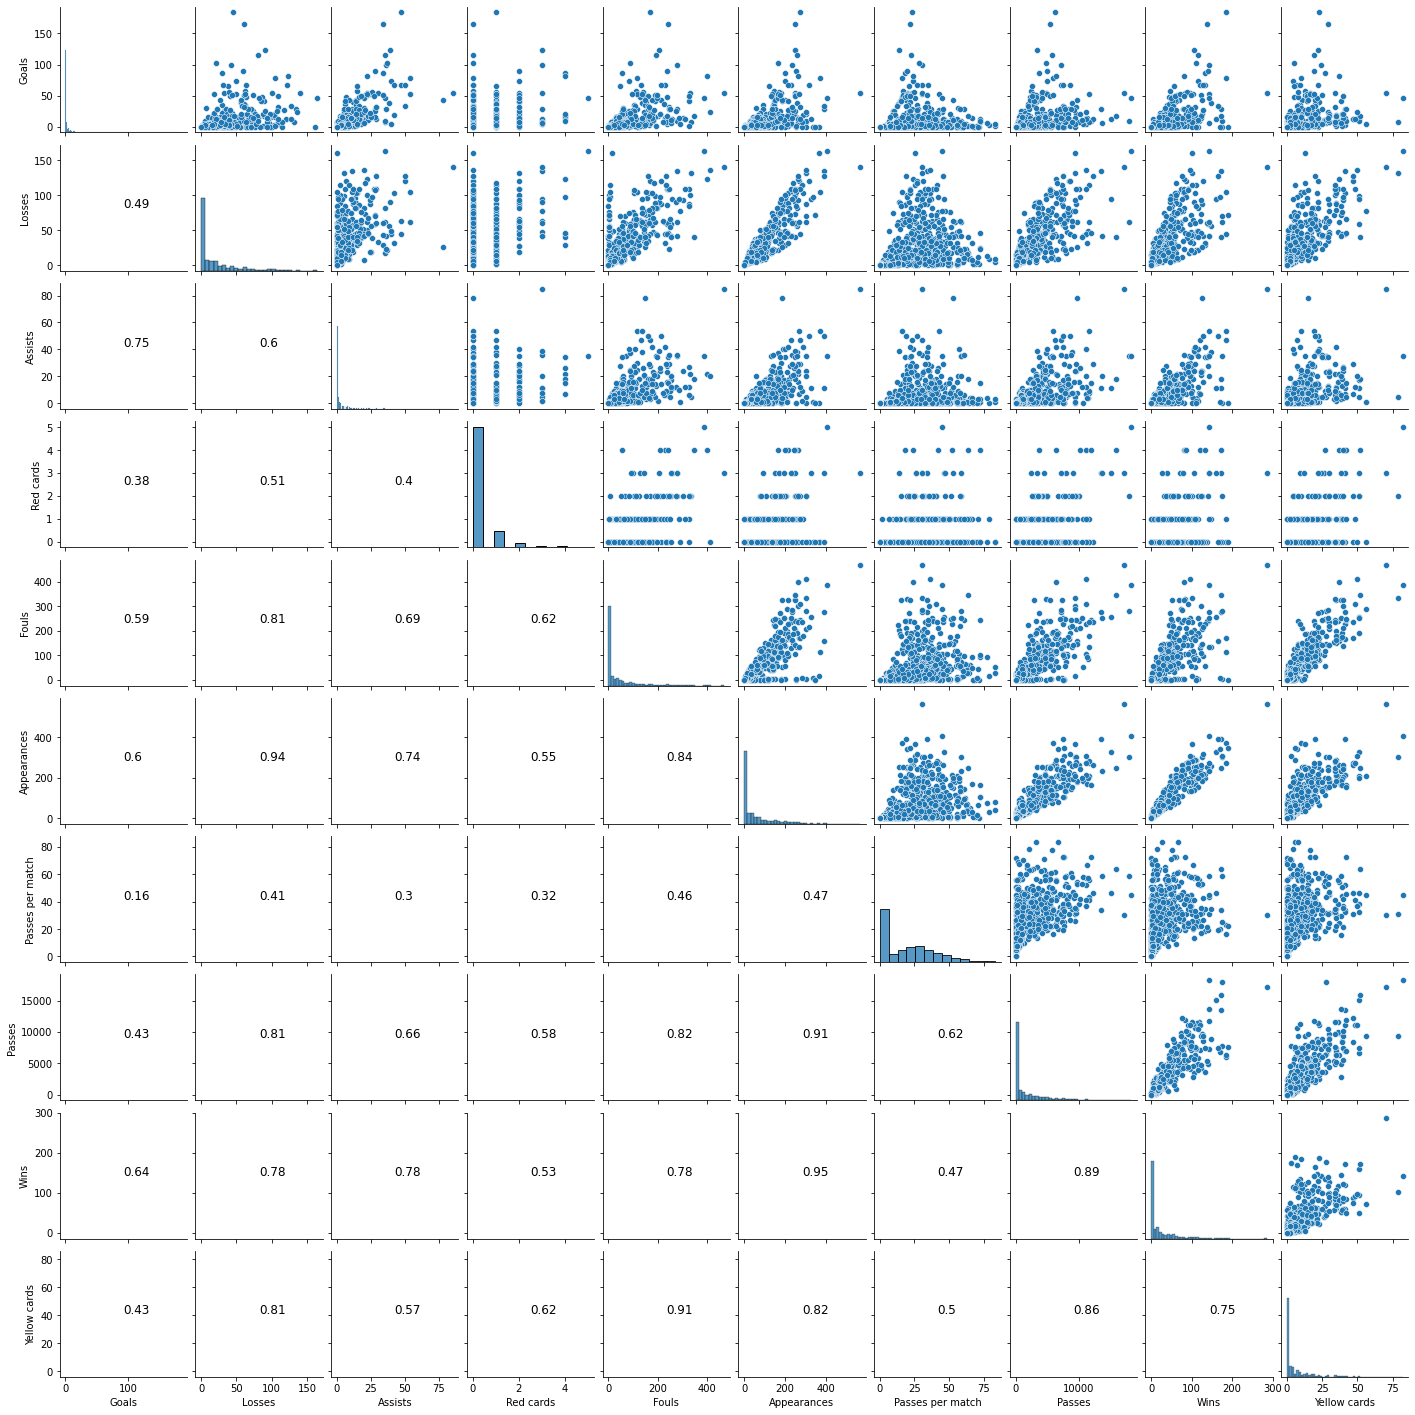

In [6]:
plot_pares(datos)

la grafica nos muestra graficos por pares, las distribuciones y las correlaciones lineales de las variables numericas, este grafico nos permite entender como se relacionan las variables entre si

#### escalamos las datos para que esten en el mismo rango [0, 1]
para todos los algoritmos basados en distancias debemos escalar los datos al mismo rango, para evitar que hayan variables que tengan mayor influencia a la hora de calcular las distancias entre puntos, en este caso usaremos `MinMaxScaler` de la libreria `sklearn`

en este ejemplo escogeremos 3 columnas para hacer el clustering, de modo que las podamos graficar en un grafico 3D

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(datos[["Goals", "Assists", "Passes"]])

scaled_data

array([[0.        , 0.04705882, 0.07827992],
       [0.        , 0.        , 0.02760887],
       [0.        , 0.        , 0.0072309 ],
       ...,
       [0.1576087 , 0.09411765, 0.42864969],
       [0.01630435, 0.03529412, 0.06458505],
       [0.        , 0.        , 0.        ]])

### evaluamos la cantidad optima de clusters

#### elbow curve

In [8]:
def elbow_curve(data, maxClusters = 15):
  from sklearn.cluster import KMeans
  
  # rango de valores del parámetro a optimizar (cantidad de clusters)
  maxClusters = range(1, maxClusters + 1)

  # se ejecuta el modelo para el rango de clusters y se guarda la inercia
  # respectiva obtenida para cada valor
  inertias = []
  for k in maxClusters:
    kmeanModel = KMeans(n_clusters = k, n_init="auto")
    kmeanModel.fit(data)
    inertias.append(kmeanModel.inertia_)

  # Grafico de los resultados obtenidos para cada valor del rango
  plt.plot(maxClusters, inertias, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Inertia')
  plt.title('Curva de codo')
  plt.show()

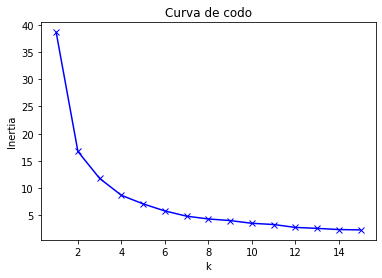

In [9]:
elbow_curve(scaled_data)

#### Estadistico de GAP

In [10]:
# nrefs es la cantidad de datos ("datasets") de referencia contra los que se va a comparar
def GAPstatistic(data, maxClusters=15, nrefs=3):
    from sklearn.cluster import KMeans
    
    gaps = np.zeros((maxClusters,))
    results = {'clusterCount':[], 'gap':[]}
    for gap_index, k in enumerate(range(1, maxClusters+1)):

        # guardara los resultados de dispersión de cada distribución simulada
        refDisps = np.zeros(nrefs)

        # Genera las muestras aleatorias indicadas con nrefs y ejecuta k-means
        # en cada bucle obteniendo los resultados de dispersión (inercia)
        # para cada conjunto generado.
        for i in range(nrefs):
            
            # Crea nuevo conjunto aleatorio de referencia
            # Se puede usar una semilla para tener reproducibilidad
            np.random.seed(0)
            randomReference = np.random.random_sample(size=data.shape)
            
            # se ajusta el modelo al conjunto de referencia
            km = KMeans(k, n_init="auto")
            km.fit(randomReference)
            # se guarda la dispersión obtenida
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Se ajusta el modelo a los datos originales y se guarda su inercia
        km = KMeans(k, n_init="auto")
        km.fit(data)
        
        origDisp = km.inertia_

        # Calcula el estadístico de gap para k clusters usando el promedio de
        # las dispersiones de los datos simulados y la dispersión de los datos originales.
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Guarda el estadístico de gap obtenido en este bucle.
        gaps[gap_index] = gap
        
        results['clusterCount'].append(k)
        results['gap'].append(gap)

    # Selecciona el "primer máximo" de los estadísticos obtenidos y devuelve 
    # su respectivo número de clusters  
    optK = 0  
    for i in range(0, len(gaps)-1):
      if gaps[i+1] <= gaps[i]:
        optK = i+1
        break
    
    plt.figure()

    plt.plot(results['clusterCount'], results['gap'], linewidth=3, marker='o')
    plt.axvline(x=optK, color='r', linestyle='--')

    plt.xlabel('Cantidad de clusters')
    plt.ylabel('Gap')
    plt.title('Estadístico de gap')
    plt.show()

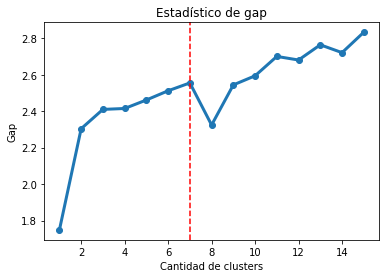

In [11]:
GAPstatistic(scaled_data)

#### Coeficiente de silueta

[documentacion sobre este metodo](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)

In [12]:
def coef_silueta(data, maxClusters=6):
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score
    import matplotlib.cm as cm

    for n_clusters in range(2, maxClusters+1):
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(19, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim(-0.1, 1)
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim(0, len(data) + (n_clusters + 1) * 10)

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init="auto")
        cluster_labels = clusterer.fit_predict(data)
        
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(data, cluster_labels)
        print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(data[:, 0], data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker=f"${i}$", alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                    "with n_clusters = %d" % n_clusters),
                    fontsize=14, fontweight='bold')

    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.7263045664277042
For n_clusters = 3 The average silhouette_score is : 0.7115091140394948
For n_clusters = 4 The average silhouette_score is : 0.6873646537328013
For n_clusters = 5 The average silhouette_score is : 0.6664475095443797
For n_clusters = 6 The average silhouette_score is : 0.6467835462524029
For n_clusters = 7 The average silhouette_score is : 0.6492580884103322


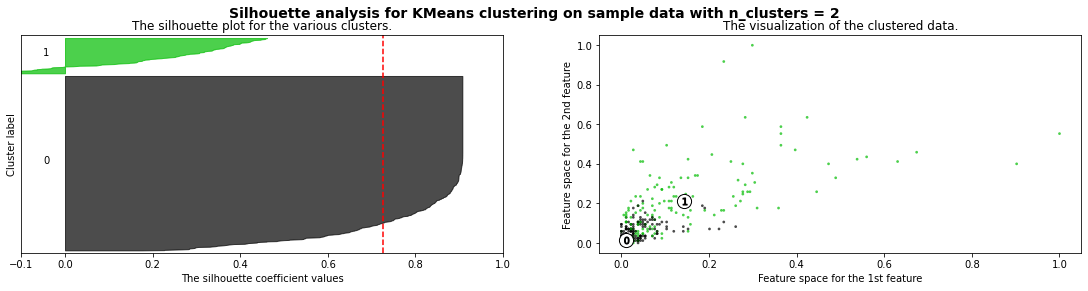

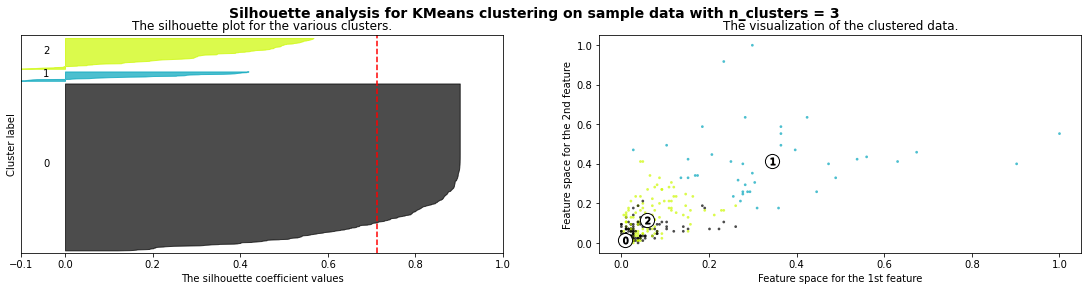

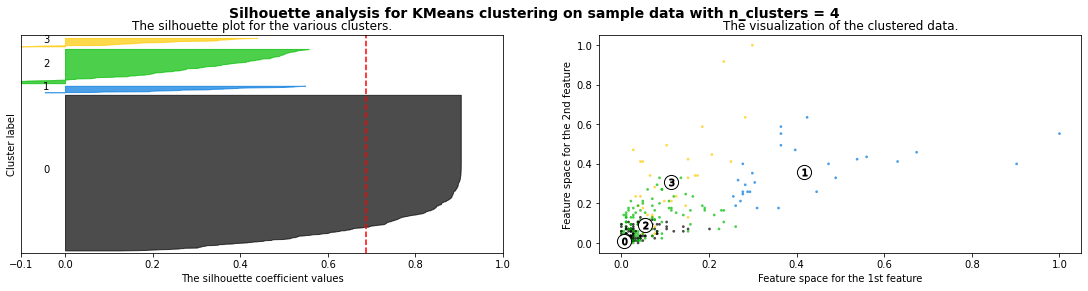

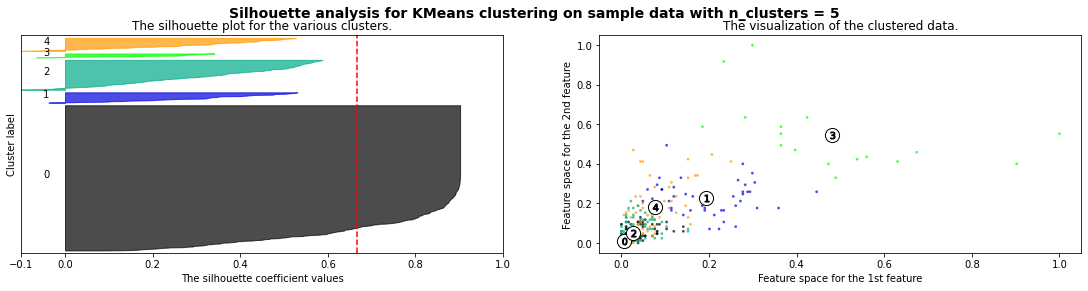

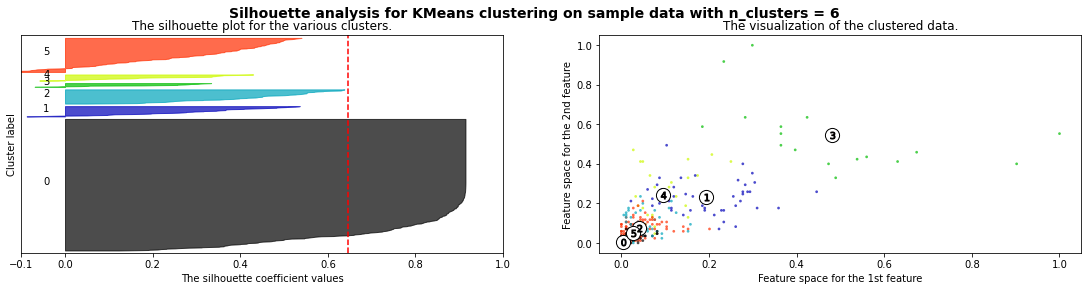

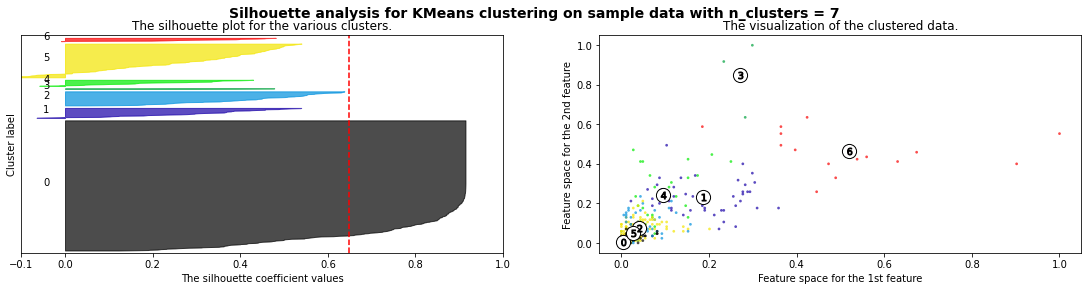

In [13]:
coef_silueta(scaled_data, 7)

### Dendograma

In [14]:
def Dendograma(data, lines=[]):
    import scipy.cluster.hierarchy as shc

    plt.figure(figsize=(15, 7))  
    plt.title("Dendrograma") 
    dend = shc.dendrogram(shc.linkage(data, method='ward'),truncate_mode='level',p=3)

    for l in lines:
        plt.axhline(y=l, color='b', linestyle='-.')
    
    plt.ylabel('Distancia euclidiana')
    plt.xlabel('puntos de datos')
    plt.show()

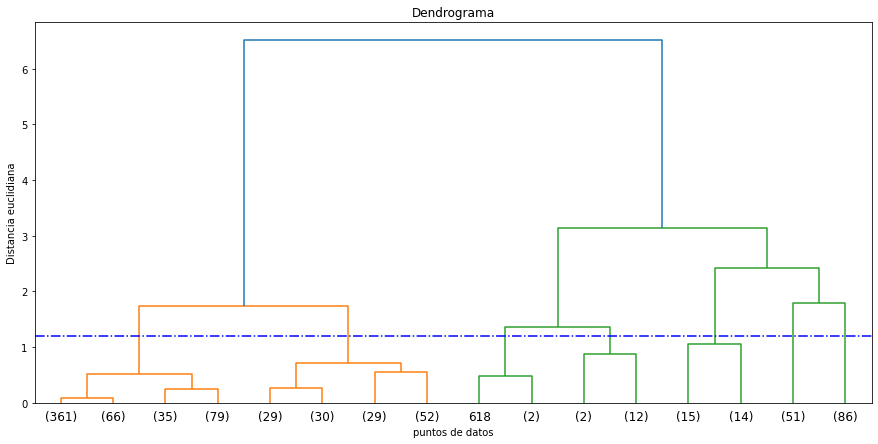

In [15]:
Dendograma(scaled_data, [1.2])

### clustering jerarquico aglomerativo

usaremos la clase `AgglomerativeClustering` de la libreria `sklearn`

In [16]:
from sklearn.cluster import AgglomerativeClustering

aggClusters = AgglomerativeClustering(n_clusters=7)
aggClusters = aggClusters.fit(scaled_data)

### clustering k-means

usaremos la clase `KMeans` de la libreria `sklearn`

In [17]:
from sklearn.cluster import KMeans

KmeansClusters = KMeans(n_clusters=7, n_init="auto")
KmeansClusters = KmeansClusters.fit(scaled_data)

### comparacion entre metodos

jugadores que fueron clasificados diferentes po cada metodo

In [18]:
print("numero de jugadores que fueron clasificados diferentes =", np.sum(aggClusters.labels_ != KmeansClusters.labels_))

numero de jugadores que fueron clasificados diferentes = 864


conteo por clase

In [19]:
display(
    "AgglomerativeClustering",
    pd.Series(aggClusters.labels_).value_counts(),
    "KMeans",
    pd.Series(KmeansClusters.labels_).value_counts()
)

'AgglomerativeClustering'

5    541
2    140
0     86
4     51
1     29
3     14
6      3
dtype: int64

'KMeans'

0    554
6    148
1     69
3     43
2     29
5     11
4     10
dtype: int64

### Caracterizacion de los datos por cluster

#### grafico 3D

In [20]:
from plotly.express import scatter_3d

datos["cluster"] = aggClusters.labels_

fig = scatter_3d(
    datos,
    x="Goals",
    y="Assists",
    z="Passes",
    color="cluster",
)

fig.show()

#### graficar la media de cada variable por cluster

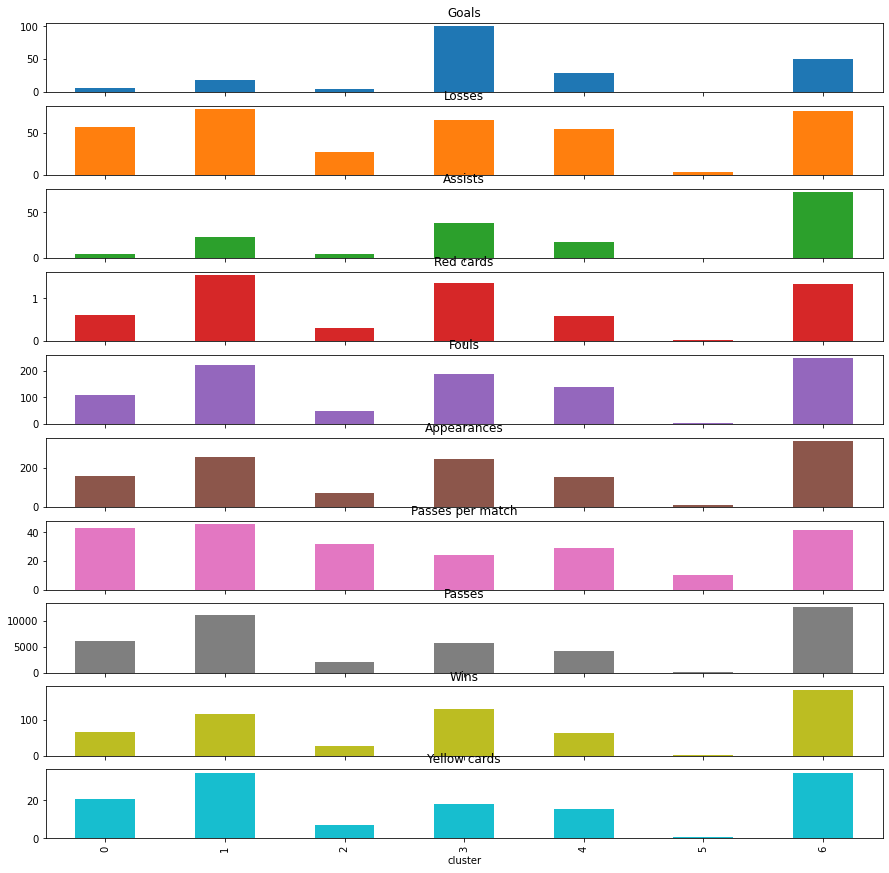

In [21]:
grouped_data = datos.groupby("cluster").mean()

grouped_data.plot.bar(subplots=True, figsize=(15, 15), legend=False)

plt.show()

#### Podemos ver un las estadisticas de un jugador en especifico

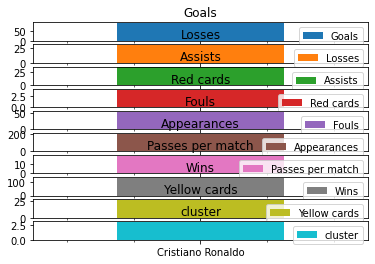

In [23]:
filtro = datos["Name"].str.contains("Cristiano")
datos.loc[filtro, datos.columns.drop("Passes")].plot.bar(subplots=True)

plt.xticks(ticks=plt.gca().get_xticks(), labels=["Cristiano Ronaldo"], rotation=0)
plt.show()

#### ejemplos de jugadores por cluster

mostrar los 5 primeros jugadores de cada cluster

In [ ]:
datos.groupby("cluster")["Name"].apply(lambda player: ", ".join(player[:5]))

#### ejemplos de jugador por cluster y posicion

mostrar los primeros 5 jugadores agrupados por cluster y posicion

In [ ]:
datos.groupby(["cluster", "Position"])["Name"].apply(lambda player: ", ".join(player[:5]))

#### prediccion de cluster de un nuevo jugador

##### para predecir el cluster de un nuevo jugador debemos seguir los mismos pasos que para el clustering, es decir, escalar los datos y aplicar el algoritmo de clustering

no podemos hacer predicciones con el metodo aglomerativo, ya que el añadir un nuevo punto, puede cambiar completamente el como se generan los clusters en este metodo

In [ ]:
jugador_nuevo = pd.DataFrame({"Goals": np.random.uniform(0, 180), "Assists": np.random.uniform(0, 80), "Passes": np.random.uniform(0, 18000)}, index=[0])
jugador_nuevo = scaler.transform(jugador_nuevo)

print("jugador nuevo =", scaler.inverse_transform(jugador_nuevo)[0])
print("cluster asignado al jugador nuevo =", KmeansClusters.predict(jugador_nuevo)[0])